In [2]:
# load packages
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import pcntoolkit as pcn
import pickle

from scipy.stats import shapiro

from enigmatoolbox.utils.parcellation import parcel_to_surface
from enigmatoolbox.plotting import plot_cortical, plot_subcortical
from enigmatoolbox.utils.useful import reorder_sctx

from pcntoolkit.normative import estimate, predict, evaluate
from pcntoolkit.util.utils import compute_MSLL, create_design_matrix

ext_scripts_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/braincharts/scripts')
os.chdir(ext_scripts_dir)

from nm_utils import remove_bad_subjects, load_2d

code_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/code')
os.chdir(code_dir)

# importing custom functions
import clinics_desc_functions as custom
from clinics_desc_functions import prepare_data, plot_quality, trajectory_plotting, dk_roi_viz, load_clinics, en_qc, pretrained_adapt_small, set_seed

# set seed
set_seed()

# formatiing
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}


Random seed 42 has been set.


In [3]:
# where things are
main_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO')
models_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/models/zscores_comparison')
os.makedirs(models_dir, exist_ok=True)
cdata_dir = ('/home/barbora/Documents/Projects/2021_06_AZV_ESO/data')
fsdata_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/fs_stats')
bdata_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/backup')
images_dir = os.path.join(models_dir,'img')
os.makedirs(images_dir, exist_ok=True)
pretrained_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/braincharts')

In [4]:
# get basic parameters for pretrained models
model_name, site_names, site_ids_tr, idp_ids = custom.pretrained_ini()

In [106]:
###
# longitudinal paired controls
###
v11_cf = custom.idp_concat(os.path.join(main_dir,'models','adaptation_comparison_paired','V1'), 'v1_Z.txt', idp_ids,  'v11_cont_z.csv', t_dir= models_dir)
v12_cf = custom.idp_concat(os.path.join(main_dir,'models','adaptation_comparison_paired','V1'), 'v2_Z.txt', idp_ids,  'v12_cont_z.csv', t_dir= models_dir)

# concatenate over idps and load
v1_cont_z = pd.read_csv(v11_cf, sep = ' ', index_col=0)
v2_cont_z = pd.read_csv(v12_cf, sep = ' ', index_col=0)

# load original patient data with clinics
v1_cont_clin = pd.read_csv('/home/barbora/Documents/Projects/Normative_Models/ESO/models/adaptation_comparison_paired/v1_common.csv',index_col=0, sep = ' ', usecols=range(0,9))
v2_cont_clin = pd.read_csv('/home/barbora/Documents/Projects/Normative_Models/ESO/models/adaptation_comparison_paired/v2_common.csv',index_col=0, sep = ' ', usecols=range(0,9))

v1_cont_orig = pd.read_csv('/home/barbora/Documents/Projects/Normative_Models/ESO/models/adaptation_comparison_paired/v1_common.csv',index_col=0, sep = ' ')
v2_cont_orig = pd.read_csv('/home/barbora/Documents/Projects/Normative_Models/ESO/models/adaptation_comparison_paired/v2_common.csv',index_col=0, sep = ' ')

# change index before concatenation
v1_cont_z.index = v1_cont_clin.index
v2_cont_z.index = v2_cont_clin.index

# concatenate
v1_cont = pd.concat([v1_cont_clin,v1_cont_z],axis=1,join='inner')
v2_cont = pd.concat([v2_cont_clin,v2_cont_z],axis=1,join='inner')


In [108]:
###
# patients
###

v11_pf = custom.idp_concat(os.path.join(main_dir,'models','pretrained_v1','V1'), 'Z_predict.txt', idp_ids,  'v11_pat_z.csv', t_dir= models_dir)
v12_pf = custom.idp_concat(os.path.join(main_dir,'models','pretrained_v1','V2'), 'Z_predict.txt', idp_ids,  'v12_pat_z.csv', t_dir= models_dir)

# concatenate over idps and load
v1_pat_z = pd.read_csv(v11_pf, sep = ' ', index_col=0)
v2_pat_z = pd.read_csv(v12_pf, sep = ' ', index_col=0)

# load clinics
v1_pat_clin = pd.read_csv(os.path.join(main_dir,'models','pretrained_v1','v1_pat.txt'), sep=' ', index_col=0, usecols=range(0,9))
v2_pat_clin = pd.read_csv(os.path.join(main_dir,'models','pretrained_v1','v2_pat.txt'), sep=' ', index_col=0, usecols=range(0,9))

v1_pat_orig_all = pd.read_csv(os.path.join(main_dir,'models','pretrained_v1','v1_pat.txt'), sep=' ', index_col=0)
v2_pat_orig_all = pd.read_csv(os.path.join(main_dir,'models','pretrained_v1','v2_pat.txt'), sep=' ', index_col=0)
# delete visit from index
v1_pat_clin.index = v1_pat_clin.index.str.slice_replace(start=-2, repl='').to_numpy()
v2_pat_clin.index = v2_pat_clin.index.str.slice_replace(start=-2, repl='').to_numpy()
v1_pat_orig_all.index = v1_pat_orig_all.index.str.slice_replace(start=-2, repl='').to_numpy()
v2_pat_orig_all.index = v2_pat_orig_all.index.str.slice_replace(start=-2, repl='').to_numpy()

# change index before concatenation
v1_pat_z.index = v1_pat_clin.index
v2_pat_z.index = v2_pat_clin.index

# concatenate
v1_pat_all = pd.concat([v1_pat_clin,v1_pat_z],axis=1,join='inner')
v2_pat_all = pd.concat([v2_pat_clin,v2_pat_z],axis=1,join='inner')

# We only want to keep patients with both visits
common = v1_pat_all.index.intersection(v2_pat_all.index)
v1_common_id = np.where(v1_pat_all.index.isin(common))
v2_common_id = np.where(v2_pat_all.index.isin(common))

v1_pat = v1_pat_all.loc[common]
v2_pat = v2_pat_all.loc[common]

v1_pat_orig = v1_pat_orig_all.loc[common]
v2_pat_orig = v2_pat_orig_all.loc[common]


In [281]:
# Finally, compute the differences
col_comp_id = np.where(v1_pat.columns.isin(idp_ids))[0]
cont_diff = (v1_cont.iloc[:,col_comp_id]) - (v2_cont.iloc[:,col_comp_id])
pat_diff = (v1_pat.iloc[:,col_comp_id]) - (v2_pat.iloc[:,col_comp_id])

# and significance of differences
# parameters of normal distribution are taken from controls
from scipy.stats import norm
pat_sig = np.empty_like(pat_diff)

for n_idp, idp in enumerate(idp_ids):
    pat_sig[:,n_idp] = 1 - norm(loc = cont_diff[idp].mean(), scale = cont_diff[idp].var()).cdf(abs(pat_diff[idp]))

df_pat_sig = pd.DataFrame(pat_sig, columns=v1_pat.columns[col_comp_id], index=pat_diff.index)

In [284]:
###
# Load dependencies for plotting
###
# which data columns do we wish to use as covariates? 
#cols_cov = ['age','sex']
# which sex do we want to plot? 
sex = 1 # 1 = male 0 = female
if sex == 1: 
    clr = 'blue'
else:
    clr = 'red'

v1_plot = v1_pat[v1_pat['sex']==sex]
v2_plot = v2_pat[v2_pat['sex']==sex]

# limits for cubic B-spline basis 
xmin = -5 
xmax = 110
model_name = 'lifespan_57K_82sites'
# Absolute Z treshold above which a sample is considered to be an outlier (without fitting any model)
outlier_thresh = 7

# create dummy data for visualisation
print('configuring dummy data ...')
xx = np.arange(xmin, xmax, 0.5)
X0_dummy = np.zeros((len(xx), 2))
X0_dummy[:,0] = xx # intercept
X0_dummy[:,1] = sex # sex covariate

X_dummy = create_design_matrix(X0_dummy, xmin=xmin, xmax=xmax, site_ids=None, all_sites=site_ids_tr)
cov_file_dummy = os.path.join(models_dir,'cov_bspline_dummy_mean.txt')
np.savetxt(cov_file_dummy, X_dummy)

#X_dummy = pd.read_csv(os.path.join(models_dir,'cov_bspline_dummy_mean.txt'),header=None, sep=' ')


# adjusting done on visit 1
visit_dir = os.path.join(main_dir,'models','pretrained_v1')

configuring dummy data ...


In [285]:
###
# Plotting longitudinal "results" of normative models
###

sns.set(style='whitegrid')

for idp_num, idp in enumerate(idp_ids): #enumerate(['lh_G&S_frontomargin_thickness']):#
    print('Running IDP', idp_num, idp, ':')
    idp_dir = os.path.join(pretrained_dir,'models',model_name, idp)
    #idp_visit_dir = os.path.join(visit_dir,idp)
    os.chdir(visit_dir)
    
    # load the true data points V1
    v1_yhat_te = load_2d(os.path.join(visit_dir,'V1',idp, 'yhat_predict.txt'))
    v1_s2_te = load_2d(os.path.join(visit_dir,'V1',idp, 'ys2_predict.txt'))
    v1_y_te = load_2d(os.path.join(visit_dir,'V1',idp, 'resp_te.txt'))
    v1_bspline = pd.DataFrame(load_2d(os.path.join(visit_dir,'V1',idp, 'cov_bspline_te.txt')))

    # load the true data points V2
    v2_yhat_te = load_2d(os.path.join(visit_dir,'V2',idp, 'yhat_predict.txt'))
    v2_s2_te = load_2d(os.path.join(visit_dir,'V2',idp, 'ys2_predict.txt'))
    v2_y_te = load_2d(os.path.join(visit_dir,'V2',idp, 'resp_te.txt'))
    v2_bspline = pd.DataFrame(load_2d(os.path.join(visit_dir,'V2',idp, 'cov_bspline_te.txt')))

    #########################################################################
    # set up the covariates for the dummy data
    print('Making predictions with dummy covariates (for visualisation)')
    yhat, s2 = predict(cov_file_dummy, 
                       alg = 'blr', 
                       respfile = None, 
                       model_path = os.path.join(idp_dir,'Models'), 
                       outputsuffix = '_dummy')
    
    # load the normative model
    with open(os.path.join(idp_dir,'Models', 'NM_0_0_estimate.pkl'), 'rb') as handle:
        nm = pickle.load(handle) 
    
    # get the warp and warp parameters
    W = nm.blr.warp
    warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 

    # warp dummy predictions to create the plots
    med, pr_int = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param)
    
    # extract the different variance components to visualise
    beta, junk1, junk2 = nm.blr._parse_hyps(nm.blr.hyp, X_dummy)
    s2n = 1/beta # variation (aleatoric uncertainty)
    s2s = s2-s2n # modelling uncertainty (epistemic uncertainty)
    #########################################################################

    #  warp predictions for the true data and compute evaluation metrics
    v1_med_te = W.warp_predictions(np.squeeze(v1_yhat_te), np.squeeze(v1_s2_te), warp_param)[0]
    v1_med_te = v1_med_te[:, np.newaxis]

    v2_med_te = W.warp_predictions(np.squeeze(v2_yhat_te), np.squeeze(v2_s2_te), warp_param)[0]
    v2_med_te = v2_med_te[:, np.newaxis]

    # load the adaptation data
    y_ad = load_2d(os.path.join(visit_dir,'V1',idp, 'resp_ad.txt'))
    X_ad = load_2d(os.path.join(visit_dir,'V1',idp, 'cov_bspline_ad.txt'))

    # pick indicies for adaptation
    idx_a = np.where(X_ad[:,2]==sex)[0] # sex index for adaptation set

    v1_idx = np.where(v1_pat['sex'] == sex)[0]
    v2_idx = np.where(v2_pat['sex'] == sex)[0]

    # y_te = np.array([v1_y_te[v1_idx],v1_y_te[v1_idx]])

    # adjust and rescale the data
    v1_y_te_rescaled, v1_s2_rescaled = nm.blr.predict_and_adjust(nm.blr.hyp, 
                                                            X_ad[idx_a,:], 
                                                            np.squeeze(y_ad[idx_a]), 
                                                            Xs=None, 
                                                            ys=np.squeeze(v1_y_te[v1_idx]))
    
    v1_y_te_rescaled_f = os.path.join(visit_dir, 'V1', idp, 'v1_y_rescaled_common'+str(sex)+'.txt')
    np.savetxt(v1_y_te_rescaled_f,v1_y_te_rescaled)

    v2_y_te_rescaled, v2_s2_rescaled = nm.blr.predict_and_adjust(nm.blr.hyp, 
                                                            X_ad[idx_a,:], 
                                                            np.squeeze(y_ad[idx_a]), 
                                                            Xs=None, 
                                                            ys=np.squeeze(v2_y_te[v2_idx]))
    
    # save transformed predictions so that we don't have to sompute this ever again
    v2_y_te_rescaled_f = os.path.join(visit_dir, 'V2', idp, 'v2_y_rescaled_common'+str(sex)+'.txt')
    np.savetxt(v2_y_te_rescaled_f,v2_y_te_rescaled)

    # plot the (adjusted) data points
    v1_plot = v1_pat[v1_pat['sex']==sex]['age'].to_numpy()
    v2_plot = v2_pat[v2_pat['sex']==sex]['age'].to_numpy()

    x_coords = np.concatenate((v1_plot[np.newaxis,:],v2_plot[np.newaxis,:]),axis=0)
    y_coords = np.concatenate((v1_y_te_rescaled[np.newaxis,:],v2_y_te_rescaled[np.newaxis,:]),axis=0)

    x_coords_sig = x_coords[:,np.where(df_pat_sig[v1_pat['sex']==sex][idp]<0.05)[0]]
    x_coords_nsig = x_coords[:,np.where(~(df_pat_sig[v1_pat['sex']==sex][idp]<0.05))[0]]

    y_coords_sig = y_coords[:,np.where(df_pat_sig[v1_pat['sex']==sex][idp]<0.05)[0]]
    y_coords_nsig = y_coords[:,np.where(~(df_pat_sig[v1_pat['sex']==sex][idp]<0.05))[0]]

    plt.figure(figsize=(8,6))
    plt.plot(x_coords_nsig, y_coords_nsig, color='gray')
    plt.plot(x_coords_sig, y_coords_sig, color='red')

    plt.scatter(v1_plot, v1_y_te_rescaled, color='darkgreen', label='V1', alpha = 0.9)
    plt.scatter(v2_plot, v2_y_te_rescaled, color='saddlebrown', label = 'V2', alpha = 0.9)

    # plot the median of the dummy data
    plt.plot(xx, med, clr)
    
    # fill the gaps in between the centiles
    junk, pr_int25 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.05,0.95])
    junk, pr_int99 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.01,0.99])
    plt.fill_between(xx, pr_int25[:,0], pr_int25[:,1], alpha = 0.1,color=clr)
    plt.fill_between(xx, pr_int95[:,0], pr_int95[:,1], alpha = 0.1,color=clr)
    plt.fill_between(xx, pr_int99[:,0], pr_int99[:,1], alpha = 0.1,color=clr)
            
    # make the width of each centile proportional to the epistemic uncertainty
    junk, pr_int25l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.05,0.95])
    junk, pr_int99l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.01,0.99])
    junk, pr_int25u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.05,0.95])
    junk, pr_int99u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.01,0.99])    
    plt.fill_between(xx, pr_int25l[:,0], pr_int25u[:,0], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int95l[:,0], pr_int95u[:,0], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int99l[:,0], pr_int99u[:,0], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int25l[:,1], pr_int25u[:,1], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int95l[:,1], pr_int95u[:,1], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int99l[:,1], pr_int99u[:,1], alpha = 0.3,color=clr)

    # plot actual centile lines
    plt.plot(xx, pr_int25[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int25[:,1],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int95[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int95[:,1],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int99[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int99[:,1],color=clr, linewidth=0.5)
    
    plt.xlabel('Age')
    plt.ylabel(idp) 
    plt.title(idp)
    plt.xlim((10,50))
    plt.legend()
    #plt.show()
    plt.savefig(os.path.join(images_dir,idp+'_'+str(sex)+'.png'))
    plt.close()
    

    
    

Running IDP 0 lh_G&S_frontomargin_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
Running IDP 1 lh_G&S_occipital_inf_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
Running IDP 2 lh_G&S_paracentral_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
Running IDP 3 lh_G&S_subcentral_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
Running IDP 4 lh_G&S_transv_frontopol_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
Running IDP 5 lh_G&S_cingul-Ant_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by mo

In [347]:
# Identifying controls with the high degree of variability
# To help QC

np_v1_cont_z = v1_cont.iloc[:,col_comp_id]
z_cont_sum = np.sum(abs(np_v1_cont_z), axis=1)

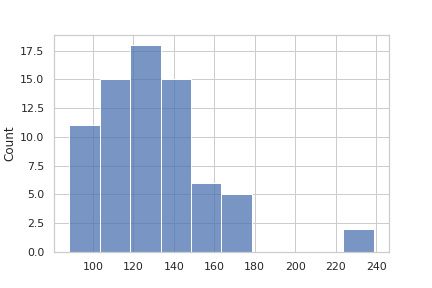

In [348]:
fig = plt.subplots(1,1)
sns.histplot(z_cont_sum)
#sns.heatmap(v1_cont_z)
plt.show()



In [349]:
temp = pd.DataFrame(z_cont_sum, index = v1_cont_z.index)
temp.sort_values(by=[0], ascending = False)

,0
C00604,238.729940
C02228,230.243417
C01887,176.086240
C01928,173.542746
C00698,168.492355
...,...
C00638,98.261626
C00607,96.051869
C00617,93.321702
C00584,92.365564


,0
C00577,123.997304
C00579,181.501968
C00584,89.663803
C00588,111.732260
C00590,124.518052
...,...
C02228,195.627052
C02236,128.540614
C02245,112.545826
C02512,154.121429
